# Assignment 2: recommender System

## Code from the lecture

In [1]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../../DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../../DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../../DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [2]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [3]:
epsilon=0.0000001 
def CosineDist(a,b):
    return a.dot(b)/(np.linalg.norm(a)*np.linalg.norm(b)+epsilon) #added epsilon for numerical stability: avoiding div by zero -> NaN

In [12]:
%%time
#again, implementation not efficient: better use lamda opperators 
D=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D[i,j]=CosineDist(R[:,i],R[:,j])

CPU times: user 2min 26s, sys: 209 ms, total: 2min 26s
Wall time: 2min 26s


In [13]:
def getTopN(movie_id, D, N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title, D):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title),D))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

In [14]:
#eucledian distance
def EuclideanDist(a,b):
    return np.linalg.norm(a-b) + epsilon

ED=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            ED[i,j]=EuclideanDist(R[:,i],R[:,j])

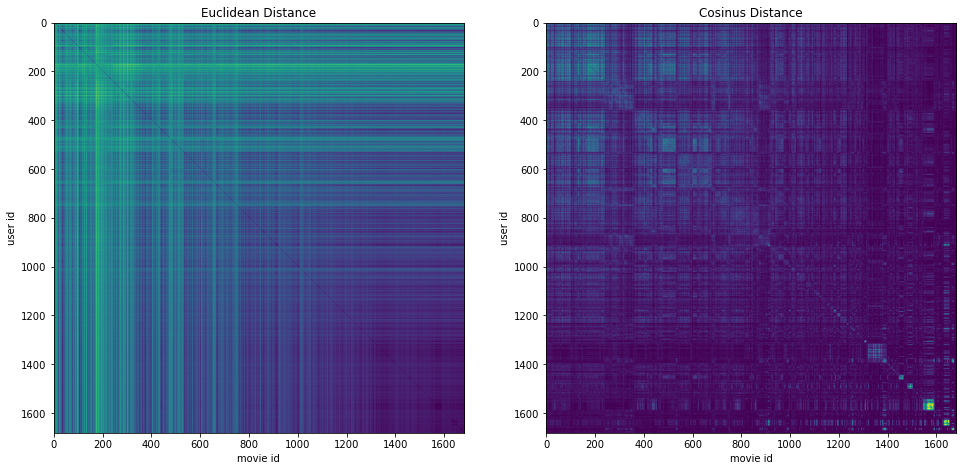

In [24]:
#graphical comparison of the distances
comp=plt.figure(figsize=(25,25))
ax1=comp.add_subplot(1,3,1)
ax1.title.set_text("Euclidean Distance")
ax1.set_xlabel("movie id")
ax1.set_ylabel("user id")
plt.imshow(ED)
ax2=comp.add_subplot(1,3,2)
ax2.title.set_text("Cosinus Distance")
ax2.set_xlabel("movie id")
ax2.set_ylabel("user id")
plt.imshow(D)
plt.show()

In [31]:
#split into train and test data
from sklearn.model_selection import train_test_split
R_train, R_test = train_test_split(R, test_size=0.1)
#calculate the scores to compare the methods
cosdist=test_Score(D, R_test)
eucdist=test_Score(ED, R_test)
print(np.mean(cosdist))
print(np.mean(eucdist))

2.408842105263158
1.5073684210526315


## 4.2 Baseline Results
Implement and compare results of two very simple baseline methods 
* random recommendations: randomly recommend 5 movies (HINT user np.random sub-library to generate random movie IDs)
* always recommending the top 5 movies: HINT: need to find the IDs of the top 5 movies over all users first

In [44]:
#random recommendations
def random_recommend(Test):
    mov_id = np.random.randint(np.shape(D)[0], size=5)  
    mov_titel = getNameByID(mov_id)
    mov_score = Test[mov_id]
    return mov_id, mov_titel, mov_score, np.mean(mov_score)

def test_random_Score(R_test):
    randomScores=[]
    for i in range(R_test.shape[0]):
        randomScore=0
        randomTop = np.argsort(R_test[i])[-5:]
        for e in randomTop:
            res_id, res_title, res_score, av_score = random_recommend(R_test[i])
            randomScore+=av_score
        randomScores.append(randomScore/(5))
    return randomScores

test_random=test_random_Score(R_test)
print(np.mean(test_random))

0.23831578947368426


In [46]:
#top 5 movies
def getTop5():
    A=np.zeros(np.shape(movies)[0])
    for i in range(0,np.shape(movies)[0]):
        A[i]=np.mean(R[:,i])    
    return A.argsort()[-5:]

def Score_Top5(Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    topmovie_id = getTop5()
    topmovie_title = getNameByID(topmovie_id)
    topmovie_score = Test[topmovie_id]
    return topmovie_id, topmovie_title, topmovie_score, np.mean(topmovie_score)

def test_Top5_Score(R_test):
    topScores=[]
    for i in range(R_test.shape[0]):
        topScore=0
        Top = np.argsort(R_test[i])[-5:]
        for e in Top:
            res_id, res_title, res_score, av_score = Score_Top5(R_test[i])
            topScore+=av_score
        topScores.append(topScore/(5))
    return topScores

test_top5=test_Top5_Score(R_test)
print(np.mean(test_top5))

2.225263157894737


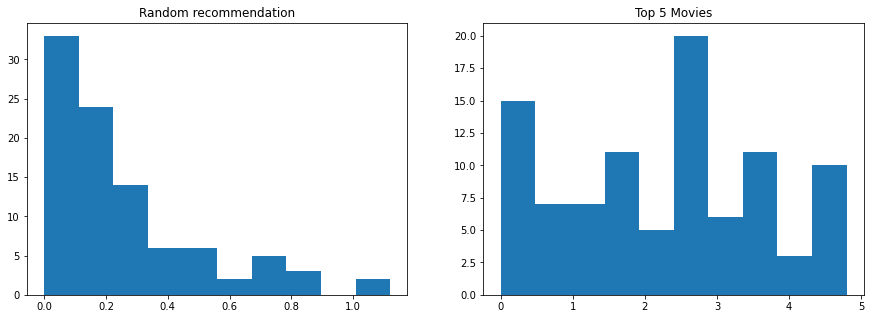

In [64]:
#graphical comparison random vs. top5
comp1=plt.figure(figsize=(15, 5))
ax1=comp1.add_subplot(1, 2, 1)
ax1.title.set_text("Random recommendation")
plt.hist(test_random)
ax2= comp1.add_subplot(1, 2, 2)
ax2.title.set_text("Top 5 Movies")
plt.hist(test_top5)

plt.show()

## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $D$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct and evaluate $D'$


In [53]:
U,S,V = np.linalg.svd(D)

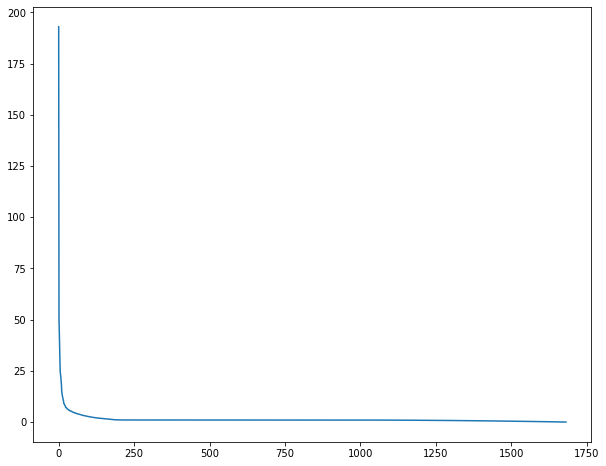

In [58]:
plt.plot(S)
plt.show()

In [76]:
cutoff=50
D_new=np.dot(U[:,:cutoff]*S[:cutoff],V[:cutoff,:])
D_new

array([[ 0.66130799,  0.40019027,  0.3276129 , ..., -0.0015137 ,
         0.04930427,  0.03230547],
       [ 0.40019027,  0.61549758,  0.27558792, ..., -0.00725404,
         0.10131351,  0.05877561],
       [ 0.3276129 ,  0.27558792,  0.47193627, ..., -0.01250711,
         0.0265887 ,  0.07835738],
       ...,
       [-0.0015137 , -0.00725404, -0.01250711, ...,  0.38583657,
        -0.00596814, -0.00194558],
       [ 0.04930427,  0.10131351,  0.0265887 , ..., -0.00596814,
         0.18115731,  0.03505996],
       [ 0.03230547,  0.05877561,  0.07835738, ..., -0.00194558,
         0.03505996,  0.08206791]])

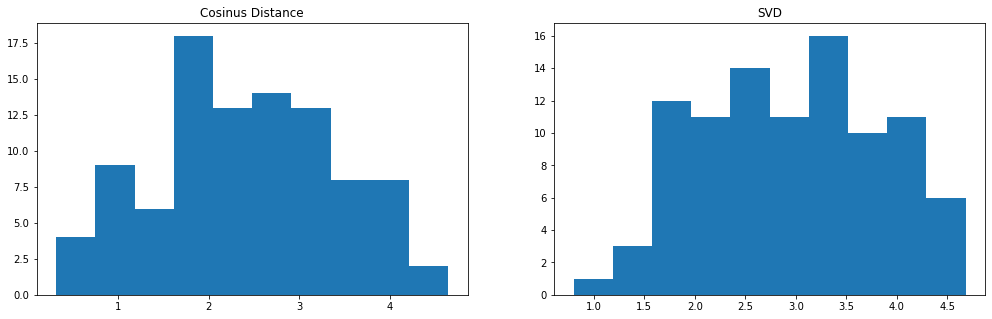

In [77]:
svdtest=test_Score(D_new, R_test)

#graphical comparison cosinus distance vs. SVD
comp2=plt.figure(figsize=(17, 5))
ax1=comp2.add_subplot(1, 2, 1)
ax1.title.set_text('Cosinus Distance')
plt.hist(cosdist)
ax2= comp2.add_subplot(1, 2, 2)
ax2.title.set_text('SVD')
plt.hist(svdtest)
plt.show()